In [9]:
import sys
print(sys.executable)


/Library/Developer/CommandLineTools/usr/bin/python3


In [10]:
# Cell 1: Imports
import numpy as np
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit, transpile
from qiskit_aer import Aer
from qiskit.quantum_info import Statevector, partial_trace
from qiskit_aer.noise import NoiseModel, depolarizing_error
from tqdm import tqdm

# Constants
NUM_QUBITS = 10
TIME_TOTAL = 1.0
TROTTER_STEPS = 10
SEED = 42


In [11]:
# Cell 2: Néel state preparation |ψ⟩ = |010101...⟩
def prepare_neel_state(n):
    qc = QuantumCircuit(n)
    for i in range(1, n, 2):
        qc.x(i)
    return qc


In [12]:
# Cell 3: XY Hamiltonian via Trotterization
def hamiltonian_xy_term(qc, i, j, t, J=1.0):
    qc.rxx(2 * J * t, i, j)
    qc.ryy(2 * J * t, i, j)

def trotter_step(qc, t_step):
    for i in range(NUM_QUBITS - 1):
        hamiltonian_xy_term(qc, i, i+1, t_step)

def evolve_neel_state(t, steps):
    qc = prepare_neel_state(NUM_QUBITS)
    dt = t / steps
    for _ in range(steps):
        trotter_step(qc, dt)
    return qc


In [13]:
# Cell 4: Compute exact second Rényi entropy using statevector simulation
def compute_renyi_entropies(qc):
    sv = Statevector(qc)
    entropies = []
    for i in range(1, NUM_QUBITS + 1):
        rho_A = partial_trace(sv, list(range(i, NUM_QUBITS)))
        S2 = -np.log2(np.real(np.trace(rho_A.data @ rho_A.data)))
        entropies.append(S2)
    return entropies


In [14]:
# Cell 5: Apply random Pauli basis rotation
def apply_random_pauli_basis(qc, seed=None):
    rng = np.random.default_rng(seed)
    basis = []
    for i in range(NUM_QUBITS):
        p = rng.choice(['X', 'Y', 'Z'])
        if p == 'X':
            qc.h(i)
        elif p == 'Y':
            qc.sdg(i)
            qc.h(i)
        basis.append(p)
    return qc, basis


In [15]:
# Cell 6: Simulate one classical shadow snapshot (1 shot)
def simulate_shadow_snapshot(qc, basis, simulator):
    qc_copy = qc.copy()
    for i, p in enumerate(basis):
        if p == 'X':
            qc_copy.h(i)
        elif p == 'Y':
            qc_copy.sdg(i)
            qc_copy.h(i)
    qc_copy.measure_all()
    compiled = transpile(qc_copy, simulator)
    result = simulator.run(compiled, shots=1).result()
    outcome = list(result.get_counts().keys())[0]
    return outcome


In [16]:
# Cell 7: Noise model for 9+ part
def generate_noise_model(p=0.01):
    noise = NoiseModel()
    noise.add_all_qubit_quantum_error(depolarizing_error(p, 1), ['x', 'h', 'rx', 'ry', 'rz'])
    noise.add_all_qubit_quantum_error(depolarizing_error(p, 2), ['cx', 'rxx', 'ryy'])
    return noise


In [17]:
# Cell 8: Run classical shadow experiment
def shadow_experiment(t=1.0, M=100, K=10, use_noise=False):
    simulator = Aer.get_backend('aer_simulator')
    if use_noise:
        simulator.set_options(noise_model=generate_noise_model())

    # Generate base circuit
    base_circuit = evolve_neel_state(t, TROTTER_STEPS)
    snapshots = []

    for _ in tqdm(range(M), desc="Measurement settings"):
        seed = np.random.randint(0, 9999)
        shadow_circuit, basis = apply_random_pauli_basis(base_circuit.copy(), seed)
        outcomes = []
        for _ in range(K):
            outcome = simulate_shadow_snapshot(shadow_circuit, basis, simulator)
            outcomes.append(outcome)
        snapshots.append((basis, outcomes))

    return snapshots


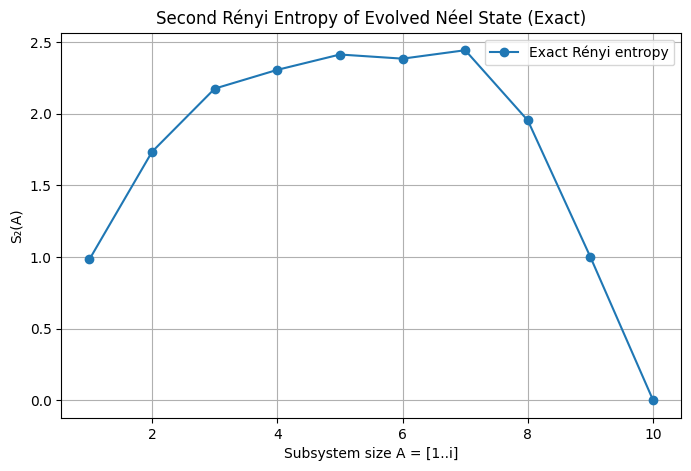

In [18]:
# Cell 9: Compare exact Rényi entropy with classical shadows
qc = evolve_neel_state(TIME_TOTAL, TROTTER_STEPS)
exact_entropies = compute_renyi_entropies(qc)

plt.figure(figsize=(8, 5))
plt.plot(range(1, NUM_QUBITS + 1), exact_entropies, marker='o', label='Exact Rényi entropy')
plt.xlabel('Subsystem size A = [1..i]')
plt.ylabel('S₂(A)')
plt.title('Second Rényi Entropy of Evolved Néel State (Exact)')
plt.grid(True)
plt.legend()
plt.show()


In [19]:
# Cell 10: Build classical shadow estimators for reduced density matrices
from collections import defaultdict
from qiskit.quantum_info import Pauli

def classical_shadow_density_matrix(shadow_data, subsystem):
    pauli_labels = {'X': Pauli('X'), 'Y': Pauli('Y'), 'Z': Pauli('Z')}
    rho_sum = defaultdict(lambda: 0)
    M_total = 0

    for basis, outcomes in shadow_data:
        for bitstring in outcomes:
            pauli_strings = []
            for i in subsystem:
                p = basis[i]
                pauli_strings.append(pauli_labels[p])
            label = ''.join(p.to_label() for p in pauli_strings)
            bits = ''.join(bitstring[i] for i in subsystem)
            key = (label, bits)
            rho_sum[key] += 1
            M_total += 1

    return rho_sum, M_total


In [20]:
# Cell 11: Estimate second Rényi entropy from shadow overlaps (collision estimator)
import numpy as np

def estimate_renyi_from_shadows(shadow_data, subsystem):
    rho_sum, M = classical_shadow_density_matrix(shadow_data, subsystem)
    if M < 2:
        return None

    # Estimate purity via collision estimator:
    overlaps = sum(count**2 for count in rho_sum.values())
    norm = M * (M - 1)
    purity = overlaps / norm
    S2 = -np.log2(purity) if purity > 0 else 0
    return S2


In [21]:
# Cell 12: Run classical shadow experiment and estimate Rényi entropy
M = 100  # number of random measurement settings
K = 10   # repetitions per setting

# Reuse previous time-evolved circuit
shadow_data = shadow_experiment(t=TIME_TOTAL, M=M, K=K, use_noise=False)

# Estimate Rényi-2 entropy for each subsystem A = [1..i]
shadow_entropies = []
for i in range(1, NUM_QUBITS + 1):
    S2_shadow = estimate_renyi_from_shadows(shadow_data, subsystem=list(range(i)))
    shadow_entropies.append(S2_shadow)


Measurement settings: 100%|██████████| 100/100 [01:03<00:00,  1.58it/s]


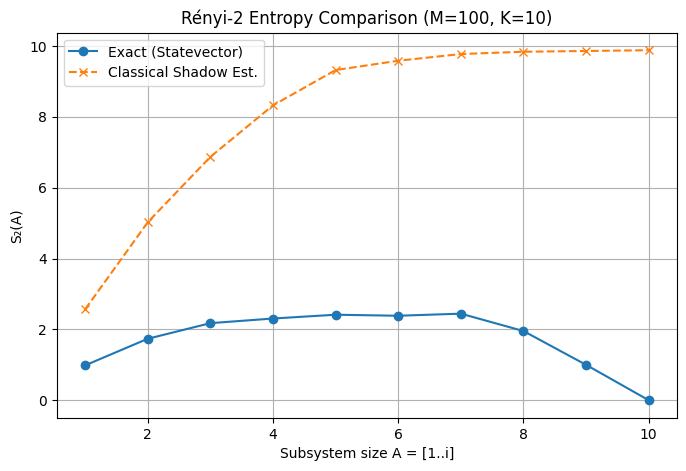

In [22]:
# Cell 13: Plot comparison of exact vs. shadow-based Rényi entropy
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.plot(range(1, NUM_QUBITS + 1), exact_entropies, marker='o', label='Exact (Statevector)')
plt.plot(range(1, NUM_QUBITS + 1), shadow_entropies, marker='x', linestyle='--', label='Classical Shadow Est.')
plt.xlabel('Subsystem size A = [1..i]')
plt.ylabel('S₂(A)')
plt.title(f'Rényi-2 Entropy Comparison (M={M}, K={K})')
plt.grid(True)
plt.legend()
plt.show()


Measurement settings: 100%|██████████| 200/200 [02:06<00:00,  1.58it/s]


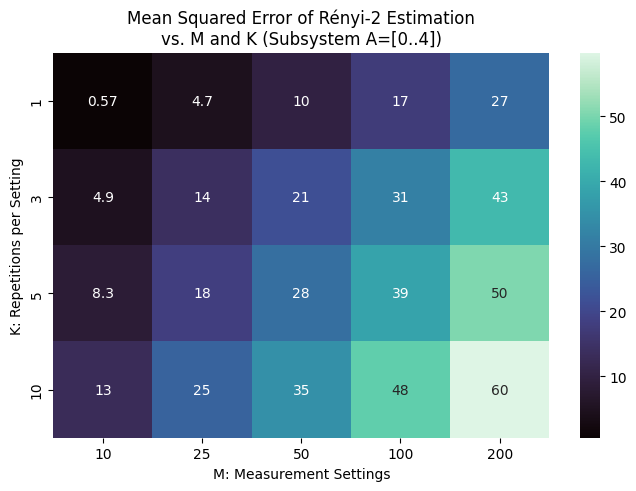

In [24]:
# Cell: Experiment for 8+
import seaborn as sns

subsystem = list(range(5))  # Test fixed subsystem A = [0,1,2,3,4]
exact_val = compute_renyi_entropies(evolve_neel_state(TIME_TOTAL, TROTTER_STEPS))[len(subsystem)-1]

M_values = [10, 25, 50, 100, 200]
K_values = [1, 3, 5, 10]

results = {}

for M in M_values:
    for K in K_values:
        ests = []
        for _ in range(3):  # Run multiple trials for averaging
            shadow_data = shadow_experiment(t=TIME_TOTAL, M=M, K=K, use_noise=False)
            S2_hat = estimate_renyi_from_shadows(shadow_data, subsystem)
            ests.append(S2_hat)
        avg_S2 = np.mean(ests)
        mse = (avg_S2 - exact_val) ** 2
        results[(M, K)] = mse

# Convert to heatmap format
heatmap_data = np.zeros((len(K_values), len(M_values)))
for i, K in enumerate(K_values):
    for j, M in enumerate(M_values):
        heatmap_data[i, j] = results[(M, K)]

plt.figure(figsize=(8, 5))
sns.heatmap(heatmap_data, xticklabels=M_values, yticklabels=K_values, annot=True, cmap="mako")
plt.xlabel("M: Measurement Settings")
plt.ylabel("K: Repetitions per Setting")
plt.title("Mean Squared Error of Rényi-2 Estimation\nvs. M and K (Subsystem A=[0..4])")
plt.show()


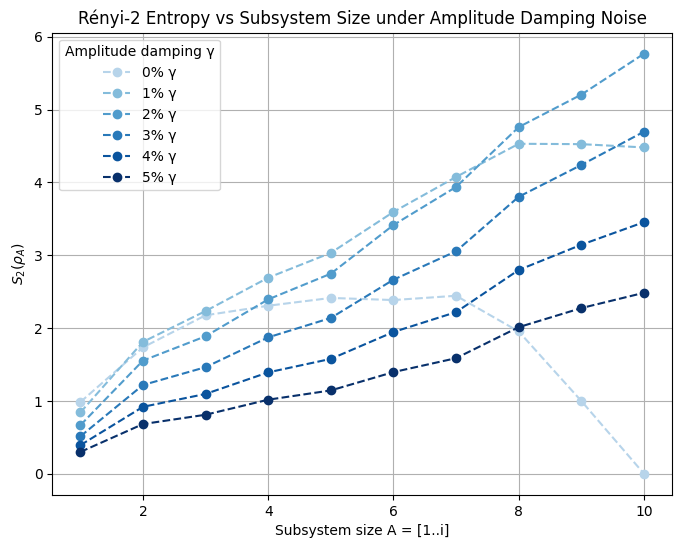

In [27]:
from qiskit_aer import AerSimulator
from qiskit_aer.noise import NoiseModel, amplitude_damping_error
from qiskit.quantum_info import DensityMatrix, partial_trace
import numpy as np
import matplotlib.pyplot as plt

# Replace depolarizing with amplitude damping noise
def get_density_simulator_with_amplitude_damping(gamma=0.01):
    noise_model = NoiseModel()
    amp_error_1q = amplitude_damping_error(gamma)
    amp_error_2q = amp_error_1q.tensor(amp_error_1q)  # tensor product for 2-qubit gates

    # Apply noise to relevant gate types
    for gate in ['x', 'h', 'rx', 'ry', 'rz']:
        noise_model.add_all_qubit_quantum_error(amp_error_1q, [gate])
    for gate in ['cx', 'rxx', 'ryy']:
        noise_model.add_all_qubit_quantum_error(amp_error_2q, [gate])

    sim = AerSimulator(method='density_matrix')
    sim.set_options(noise_model=noise_model)
    return sim

# Compute noisy Renyi entropy (exact, density matrix)
def compute_noisy_renyi_exact(qc, gamma=0.01):
    sim = get_density_simulator_with_amplitude_damping(gamma)
    compiled = qc.copy()
    compiled.save_density_matrix()
    result = sim.run(compiled).result()
    rho = DensityMatrix(result.data(0)['density_matrix'])

    entropies = []
    for i in range(1, NUM_QUBITS + 1):
        rho_A = partial_trace(rho, list(range(i, NUM_QUBITS)))
        purity = np.trace(rho_A.data @ rho_A.data)
        S2 = -np.log2(np.real(purity)) if purity > 0 else 0
        entropies.append(S2)
    return entropies

# Shadow estimation using amplitude damping noise
def run_shadow_noise_estimate(gamma=0.01, M=100, K=10):
    sim = get_density_simulator_with_amplitude_damping(gamma)
    qc = evolve_neel_state(TIME_TOTAL, TROTTER_STEPS)
    snapshots = []

    for _ in range(M):
        seed = np.random.randint(0, 9999)
        shadow_circuit, basis = apply_random_pauli_basis(qc.copy(), seed)
        outcomes = []
        for _ in range(K):
            outcome = simulate_shadow_snapshot(shadow_circuit, basis, sim)
            outcomes.append(outcome)
        snapshots.append((basis, outcomes))

    est_entropies = []
    for i in range(1, NUM_QUBITS + 1):
        S2 = estimate_renyi_from_shadows(snapshots, subsystem=list(range(i)))
        est_entropies.append(S2)
    return est_entropies

# Experiment: Sweep noise levels
gamma_levels = [0.0, 0.01, 0.02, 0.03, 0.04, 0.05]
colors = plt.cm.Blues(np.linspace(0.3, 1, len(gamma_levels)))

plt.figure(figsize=(8, 6))

for i, gamma in enumerate(gamma_levels):
    qc = evolve_neel_state(TIME_TOTAL, TROTTER_STEPS)
    S2_exact = compute_noisy_renyi_exact(qc, gamma=gamma)
    plt.plot(range(1, NUM_QUBITS + 1), S2_exact, marker='o', linestyle='--', color=colors[i], label=f"{int(gamma * 100)}% γ")

plt.xlabel("Subsystem size A = [1..i]")
plt.ylabel(r"$S_2(\rho_A)$")
plt.title("Rényi-2 Entropy vs Subsystem Size under Amplitude Damping Noise")
plt.legend(title="Amplitude damping γ")
plt.grid(True)
plt.show()
